**Static vs Dynamic Classification for Averaged Dataset**

Notebook contains experiments using 1D-CNN and LSTM models. Experiments were run using K fold and Group K fold cross validation with the raw data as well as the scaled data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#switch to directory with dataset
%cd drive/My\ Drive/dat_files

In [3]:
#imports
import pandas as pd
import glob
from os.path import splitext
import os
import numpy as np
from matplotlib import pyplot as plt     
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler, Normalizer

**Load data**

In [6]:
fear_files = np.array([])
#labels file as 01 for static, 0 for dynamic
fear_labels = np.array([], dtype=int)
#saves participant number as group
fear_groups = np.array([], dtype=int)

#go through fear files
for file in glob.iglob("*_1*.csv"):
  fear_files = np.append(fear_files, file)
  fear_groups = np.append(fear_groups, file[2:4])
  #label as static or dynamic
  if file[6] == '1':
    fear_labels = np.append(fear_labels, 0)
  else:
    fear_labels = np.append(fear_labels, 1)

anger_files = np.array([])
#labels file as 1 for static, 0 for dynamic
anger_labels = np.array([], dtype=int)
#saves participant number as group
anger_groups = np.array([], dtype=int)

#go through anger files
for file in glob.iglob("*_2*.csv"):
  anger_files = np.append(anger_files, file)
  anger_groups = np.append(anger_groups, file[2:4])
  #label as static or dynamic
  if file[6] == '1':
    anger_labels = np.append(anger_labels, 0)
  else:
    anger_labels = np.append(anger_labels, 1)

**Make into DFs and clean up channel names**

In [5]:
#list to hold dataframes
dfs = []
#rows to skip
skip_rows = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19])

#read in static csvs as pandas df
for x in range(0, fear_files.size):
  df = pd.read_csv(fear_files[x], sep='\t', skiprows=skip_rows, header=(0))
  #remove whitespace from channel names
  for y in range(0, len(df.columns)):
    ch_name = df.iloc[0:,y].name
    #remove whitespace
    new_name = ''.join(ch_name.split())
    #rename column
    df.rename(columns={ch_name: new_name}, inplace=True)

  #append df to list  
  dfs.append(df)

#convert list to np array
fear_dfs = np.empty(fear_files.size, dtype=object)
fear_dfs[:] = [dfs[0]]

In [7]:
#list to hold dataframes
dfs = []
#rows to skip
skip_rows = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19])

#read in static csvs as pandas df
for x in range(0, anger_files.size):
  df = pd.read_csv(anger_files[x], sep='\t', skiprows=skip_rows, header=(0))
  #remove whitespace from channel names
  for y in range(0, len(df.columns)):
    ch_name = df.iloc[0:,y].name
    #remove whitespace
    new_name = ''.join(ch_name.split())
    #rename column
    df.rename(columns={ch_name: new_name}, inplace=True)

  #append df to list  
  dfs.append(df)

#convert list to np array
anger_dfs = np.empty(anger_files.size, dtype=object)
anger_dfs[:] = [dfs[0]]

**Drop non-EEG channels**

In [8]:
for x in range(0, fear_dfs.size):
  if "[HEO]" in fear_dfs[x].columns:
    fear_dfs[x].drop(columns=["[HEO]"], inplace=True)
  if "[VEO]" in fear_dfs[x].columns:
    fear_dfs[x].drop(columns=["[VEO]"], inplace=True)
  if "Unnamed:65" in fear_dfs[x].columns:
    fear_dfs[x].drop(columns=["Unnamed:65"], inplace=True)
  if "Unnamed:66" in fear_dfs[x].columns:
    fear_dfs[x].drop(columns=["Unnamed:66"], inplace=True)

for x in range(0, anger_dfs.size):
  if "[HEO]" in anger_dfs[x].columns:
    anger_dfs[x].drop(columns=["[HEO]"], inplace=True)
  if "[VEO]" in anger_dfs[x].columns:
    anger_dfs[x].drop(columns=["[VEO]"], inplace=True)
  if "Unnamed:65" in anger_dfs[x].columns:
    anger_dfs[x].drop(columns=["Unnamed:65"], inplace=True)
  if "Unnamed:66" in anger_dfs[x].columns:
    anger_dfs[x].drop(columns=["Unnamed:66"], inplace=True)

**Convert DFs to 3D NumPy array (samples, rows, cols)**

In [9]:
fear_nps = []

for x in range(0, fear_dfs.size):
  #200 to 600 ms timeframe
  fear_nps.append(fear_dfs[x].to_numpy())
  #.iloc[200:601]

#convert to numpy array
fear_nps = np.asarray(fear_nps)

anger_nps = []

for x in range(0, anger_dfs.size):
  anger_nps.append(anger_dfs[x].to_numpy())
  #.iloc[200:601]

#convert to numpy array
anger_nps = np.asarray(anger_nps)

**Create Model(s)**

In [21]:
#creates 1D-CNN Model
def create_cnn_model():
  #variables to be used for input shape
  ROWS = 1101
  COLS = 64

  model = Sequential()
  #add 2 1D Convolution Layers
  model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(ROWS, COLS)))
  model.add(MaxPooling1D(pool_size=2))
  #model.add(Conv1D(filters=64, kernel_size=7, activation='relu')) 
  #downsample input representation
  #model.add(MaxPooling1D(pool_size=2))
  #model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(64, activation='relu', name='first_dense'))
  #model.add(Dense(64, activation='relu', name='2nd_dense'))
  model.add(Dense(1, activation='sigmoid'))

  #compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

  return model

In [10]:
#Creates LSTM Model
def create_lstm_model():
  #variables to be used for input shape
  ROWS = 1101
  COLS = 64
  
  #Double Bidirectional LSTM layer model
  model = tf.keras.Sequential([
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
  ])
  #compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
  
  return model

**Confusion Matrix**

In [11]:
from sklearn.metrics import confusion_matrix
import itertools
#for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    diff = cm.max() - cm.min()
    thresh = cm.min() + (diff/2.)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            fontsize='xx-large',
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Group K fold cross validation**

Train on 36 samples, validate on 10 samples
Epoch 1/25
 - 1s - loss: 14.9853 - accuracy: 0.4167 - val_loss: 0.7071 - val_accuracy: 0.5000
Epoch 2/25
 - 0s - loss: 0.9159 - accuracy: 0.5278 - val_loss: 1.0969 - val_accuracy: 0.5000
Epoch 3/25
 - 0s - loss: 0.8651 - accuracy: 0.5000 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 4/25
 - 0s - loss: 0.8113 - accuracy: 0.3611 - val_loss: 0.6977 - val_accuracy: 0.5000
Epoch 5/25
 - 0s - loss: 0.7503 - accuracy: 0.3889 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 6/25
 - 0s - loss: 0.7367 - accuracy: 0.3333 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 7/25
 - 0s - loss: 0.7348 - accuracy: 0.4444 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 8/25
 - 0s - loss: 0.7244 - accuracy: 0.5000 - val_loss: 0.7096 - val_accuracy: 0.5000
Epoch 9/25
 - 0s - loss: 0.7352 - accuracy: 0.3889 - val_loss: 0.7033 - val_accuracy: 0.5000
Epoch 10/25
 - 0s - loss: 0.8609 - accuracy: 0.5000 - val_loss: 0.8454 - val_accuracy: 0.5000
Epoch 11/25
 - 0s - loss

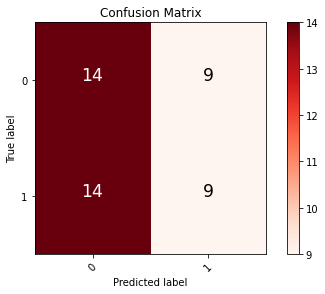

In [ ]:
#fear files
n_epochs = 25
n_splits = 5
batch_size = 1
verbose = 2

class_names = [0, 1]

accuracies = []
losses = []

predicts = []
trues = []

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(fear_nps, fear_labels, fear_groups):
  #split data into X and y training and test sets
  fear_X_train, fear_X_test = fear_nps[train_index], fear_nps[test_index]
  fear_y_train, fear_y_test = fear_labels[train_index], fear_labels[test_index]

  #build model
  model = create_cnn_model()
  
  #fit model
  history = model.fit(fear_X_train, fear_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(fear_X_test, fear_y_test))
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = fear_y_test
  y_pred_prob = model.predict(fear_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)

  #evaluate model
  loss, accuracy = model.evaluate(fear_X_test, fear_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

Train on 38 samples, validate on 9 samples
Epoch 1/25
 - 0s - loss: 22.5569 - accuracy: 0.3421 - val_loss: 0.7624 - val_accuracy: 0.4444
Epoch 2/25
 - 0s - loss: 0.7075 - accuracy: 0.3947 - val_loss: 1.2335 - val_accuracy: 0.4444
Epoch 3/25
 - 0s - loss: 1.1148 - accuracy: 0.3421 - val_loss: 0.6940 - val_accuracy: 0.5556
Epoch 4/25
 - 0s - loss: 0.8311 - accuracy: 0.5000 - val_loss: 0.8808 - val_accuracy: 0.4444
Epoch 5/25
 - 0s - loss: 0.7134 - accuracy: 0.5526 - val_loss: 0.7171 - val_accuracy: 0.5556
Epoch 6/25
 - 0s - loss: 0.8646 - accuracy: 0.5000 - val_loss: 0.6889 - val_accuracy: 0.5556
Epoch 7/25
 - 0s - loss: 0.7337 - accuracy: 0.5526 - val_loss: 0.8325 - val_accuracy: 0.4444
Epoch 8/25
 - 0s - loss: 0.7253 - accuracy: 0.5000 - val_loss: 0.6883 - val_accuracy: 0.5556
Epoch 9/25
 - 0s - loss: 0.7716 - accuracy: 0.5000 - val_loss: 0.7006 - val_accuracy: 0.5556
Epoch 10/25
 - 0s - loss: 0.7124 - accuracy: 0.5000 - val_loss: 0.7548 - val_accuracy: 0.4444
Epoch 11/25
 - 0s - loss:

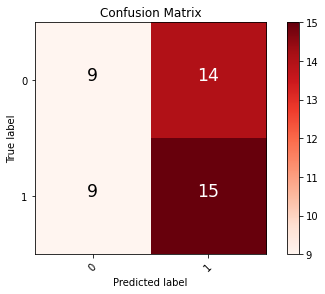

In [ ]:
#anger files
n_epochs = 25
n_splits = 5
batch_size = 8
verbose = 2

accuracies = []
losses = []
trues = []
predicts = []

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(anger_nps, anger_labels, anger_groups):
  #split data into X and y training and test sets
  anger_X_train, anger_X_test = anger_nps[train_index], anger_nps[test_index]
  anger_y_train, anger_y_test = anger_labels[train_index], anger_labels[test_index]

  #build model
  model = create_cnn_model()
  
  #fit model
  history = model.fit(anger_X_train, anger_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(anger_X_test, anger_y_test))
  
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = anger_y_test
  y_pred_prob = model.predict(anger_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)

  #evaluate model
  loss, accuracy = model.evaluate(anger_X_test, anger_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Scale data**

In [ ]:
for i in range(anger_nps.shape[0]):
    scaler = StandardScaler()
    anger_nps[i, :, :] = scaler.fit_transform(anger_nps[i, :, :]) 

print (anger_nps.shape)

for i in range(fear_nps.shape[0]):
    scaler = StandardScaler()
    fear_nps[i, :, :] = scaler.fit_transform(fear_nps[i, :, :]) 

print (fear_nps.shape)

(47, 1101, 64)
(46, 1101, 64)


**After scaling**

Train on 36 samples, validate on 10 samples
Epoch 1/25
 - 0s - loss: 5.1031 - accuracy: 0.3611 - val_loss: 1.2669 - val_accuracy: 0.5000
Epoch 2/25
 - 0s - loss: 0.7884 - accuracy: 0.5833 - val_loss: 1.6674 - val_accuracy: 0.5000
Epoch 3/25
 - 0s - loss: 0.9497 - accuracy: 0.4444 - val_loss: 1.2367 - val_accuracy: 0.5000
Epoch 4/25
 - 0s - loss: 0.8821 - accuracy: 0.2778 - val_loss: 0.6966 - val_accuracy: 0.5000
Epoch 5/25
 - 0s - loss: 0.8527 - accuracy: 0.4167 - val_loss: 0.8176 - val_accuracy: 0.5000
Epoch 6/25
 - 0s - loss: 0.8668 - accuracy: 0.4722 - val_loss: 0.9701 - val_accuracy: 0.5000
Epoch 7/25
 - 0s - loss: 0.9932 - accuracy: 0.4444 - val_loss: 0.9601 - val_accuracy: 0.5000
Epoch 8/25
 - 0s - loss: 1.2123 - accuracy: 0.6389 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 9/25
 - 0s - loss: 0.7569 - accuracy: 0.4722 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 10/25
 - 0s - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 11/25
 - 0s - loss:

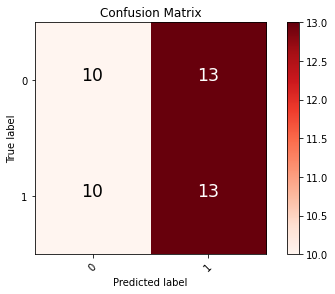

In [ ]:
#fear files
n_epochs = 25
n_splits = 5
batch_size = 1
verbose = 2

class_names = [0, 1]

accuracies = []
losses = []

predicts = []
trues = []

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(fear_nps, fear_labels, fear_groups):
  #split data into X and y training and test sets
  fear_X_train, fear_X_test = fear_nps[train_index], fear_nps[test_index]
  fear_y_train, fear_y_test = fear_labels[train_index], fear_labels[test_index]

  #build model
  model = create_cnn_model()
  
  #fit model
  history = model.fit(fear_X_train, fear_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(fear_X_test, fear_y_test))
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = fear_y_test
  y_pred_prob = model.predict(fear_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)

  #evaluate model
  loss, accuracy = model.evaluate(fear_X_test, fear_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

Train on 38 samples, validate on 9 samples
Epoch 1/25
 - 0s - loss: 5.6577 - accuracy: 0.5000 - val_loss: 0.7407 - val_accuracy: 0.4444
Epoch 2/25
 - 0s - loss: 0.8412 - accuracy: 0.4474 - val_loss: 0.9289 - val_accuracy: 0.5556
Epoch 3/25
 - 0s - loss: 0.9422 - accuracy: 0.5526 - val_loss: 1.2030 - val_accuracy: 0.4444
Epoch 4/25
 - 0s - loss: 1.5078 - accuracy: 0.3947 - val_loss: 0.7233 - val_accuracy: 0.4444
Epoch 5/25
 - 0s - loss: 0.7852 - accuracy: 0.5526 - val_loss: 0.8731 - val_accuracy: 0.5556
Epoch 6/25
 - 0s - loss: 0.8790 - accuracy: 0.3947 - val_loss: 0.6873 - val_accuracy: 0.5556
Epoch 7/25
 - 0s - loss: 0.7380 - accuracy: 0.4474 - val_loss: 0.6878 - val_accuracy: 0.5556
Epoch 8/25
 - 0s - loss: 0.9020 - accuracy: 0.3421 - val_loss: 0.6895 - val_accuracy: 0.5556
Epoch 9/25
 - 0s - loss: 0.8231 - accuracy: 0.5000 - val_loss: 0.6993 - val_accuracy: 0.5556
Epoch 10/25
 - 0s - loss: 0.8990 - accuracy: 0.4474 - val_loss: 0.7959 - val_accuracy: 0.5556
Epoch 11/25
 - 0s - loss: 

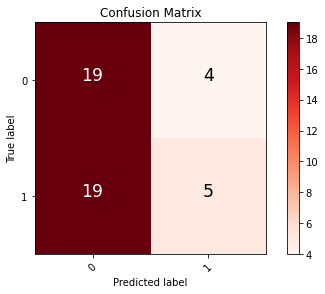

In [ ]:
#anger files
n_epochs = 25
n_splits = 5
batch_size = 8
verbose = 2

accuracies = []
losses = []
trues = []
predicts = []

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(anger_nps, anger_labels, anger_groups):
  #split data into X and y training and test sets
  anger_X_train, anger_X_test = anger_nps[train_index], anger_nps[test_index]
  anger_y_train, anger_y_test = anger_labels[train_index], anger_labels[test_index]

  #build model
  model = create_cnn_model()
  
  #fit model
  history = model.fit(anger_X_train, anger_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(anger_X_test, anger_y_test))
  
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = anger_y_test
  y_pred_prob = model.predict(anger_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)

  #evaluate model
  loss, accuracy = model.evaluate(anger_X_test, anger_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Group K fold with LSTM**

Epoch 1/25
36/36 - 12s - loss: 0.7313 - accuracy: 0.5000 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/25
36/36 - 11s - loss: 0.7416 - accuracy: 0.5000 - val_loss: 0.6979 - val_accuracy: 0.5000
Epoch 3/25
36/36 - 11s - loss: 0.7299 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/25
36/36 - 11s - loss: 0.7077 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/25
36/36 - 11s - loss: 0.7034 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 6/25
36/36 - 11s - loss: 0.6956 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/25
36/36 - 11s - loss: 0.7161 - accuracy: 0.5000 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 8/25
36/36 - 11s - loss: 0.7199 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 9/25
36/36 - 11s - loss: 0.6958 - accuracy: 0.5000 - val_loss: 0.6987 - val_accuracy: 0.5000
Epoch 10/25
36/36 - 11s - loss: 0.7101 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 11/

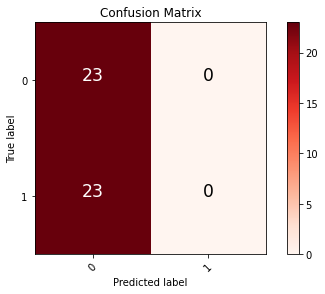

In [ ]:
#fear files
n_epochs = 25
n_splits = 5
batch_size = 1
verbose = 2

class_names = [0, 1]

accuracies = []
losses = []

predicts = []
trues = []

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(fear_nps, fear_labels, fear_groups):
  #split data into X and y training and test sets
  fear_X_train, fear_X_test = fear_nps[train_index], fear_nps[test_index]
  fear_y_train, fear_y_test = fear_labels[train_index], fear_labels[test_index]

  #build model
  model = create_lstm_model()
  
  #fit model
  history = model.fit(fear_X_train, fear_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(fear_X_test, fear_y_test))
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = fear_y_test
  y_pred_prob = model.predict(fear_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)

  #evaluate model
  loss, accuracy = model.evaluate(fear_X_test, fear_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

Epoch 1/25
5/5 - 3s - loss: 0.7038 - accuracy: 0.5000 - val_loss: 0.6891 - val_accuracy: 0.4444
Epoch 2/25
5/5 - 2s - loss: 0.7071 - accuracy: 0.5000 - val_loss: 0.6978 - val_accuracy: 0.4444
Epoch 3/25
5/5 - 2s - loss: 0.7025 - accuracy: 0.5000 - val_loss: 0.7004 - val_accuracy: 0.4444
Epoch 4/25
5/5 - 2s - loss: 0.7109 - accuracy: 0.5000 - val_loss: 0.6920 - val_accuracy: 0.4444
Epoch 5/25
5/5 - 2s - loss: 0.7119 - accuracy: 0.5000 - val_loss: 0.7017 - val_accuracy: 0.4444
Epoch 6/25
5/5 - 2s - loss: 0.6988 - accuracy: 0.5000 - val_loss: 0.6956 - val_accuracy: 0.4444
Epoch 7/25
5/5 - 2s - loss: 0.6967 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.4444
Epoch 8/25
5/5 - 2s - loss: 0.7003 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.4444
Epoch 9/25
5/5 - 2s - loss: 0.6847 - accuracy: 0.5000 - val_loss: 0.6916 - val_accuracy: 0.4444
Epoch 10/25
5/5 - 2s - loss: 0.7118 - accuracy: 0.5000 - val_loss: 0.6893 - val_accuracy: 0.4444
Epoch 11/25
5/5 - 2s - loss: 0.7130 - a

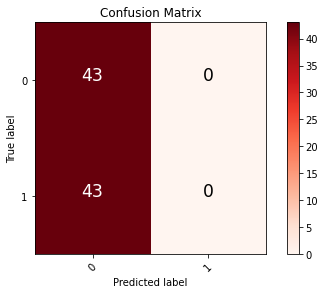

In [ ]:
#anger files
n_epochs = 25
n_splits = 5
batch_size = 8
verbose = 2

accuracies = []
losses = []

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(anger_nps, anger_labels, anger_groups):
  #split data into X and y training and test sets
  anger_X_train, anger_X_test = anger_nps[train_index], anger_nps[test_index]
  anger_y_train, anger_y_test = anger_labels[train_index], anger_labels[test_index]

  #build model
  model = create_lstm_model()
  
  #fit model
  history = model.fit(anger_X_train, anger_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(anger_X_test, anger_y_test))
  
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = fear_y_test
  y_pred_prob = model.predict(fear_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)

  #evaluate model
  loss, accuracy = model.evaluate(anger_X_test, anger_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**K fold**

Train on 36 samples, validate on 10 samples
Epoch 1/25
 - 1s - loss: 8.1625 - accuracy: 0.4444 - val_loss: 0.6766 - val_accuracy: 0.6000
Epoch 2/25
 - 0s - loss: 1.1013 - accuracy: 0.4444 - val_loss: 0.6757 - val_accuracy: 0.6000
Epoch 3/25
 - 0s - loss: 1.1258 - accuracy: 0.4444 - val_loss: 1.5666 - val_accuracy: 0.6000
Epoch 4/25
 - 0s - loss: 1.8999 - accuracy: 0.5000 - val_loss: 1.4097 - val_accuracy: 0.6000
Epoch 5/25
 - 0s - loss: 0.9874 - accuracy: 0.5278 - val_loss: 0.8266 - val_accuracy: 0.6000
Epoch 6/25
 - 0s - loss: 1.1312 - accuracy: 0.4722 - val_loss: 0.7108 - val_accuracy: 0.6000
Epoch 7/25
 - 0s - loss: 1.1421 - accuracy: 0.5556 - val_loss: 0.6780 - val_accuracy: 0.6000
Epoch 8/25
 - 0s - loss: 0.9208 - accuracy: 0.5833 - val_loss: 0.8420 - val_accuracy: 0.4000
Epoch 9/25
 - 0s - loss: 1.0113 - accuracy: 0.4722 - val_loss: 1.4811 - val_accuracy: 0.4000
Epoch 10/25
 - 0s - loss: 2.7290 - accuracy: 0.5278 - val_loss: 4.9486 - val_accuracy: 0.4000
Epoch 11/25
 - 0s - loss:

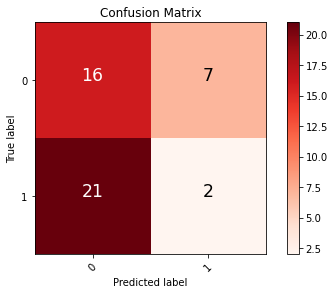

In [ ]:
#fear files
n_epochs = 25
n_splits = 5
batch_size = 1
verbose = 2

class_names = [0, 1]

accuracies = []
losses = []

predicts = []
trues = []

split_no = 1

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(fear_nps):
  #split data into X and y training and test sets
  fear_X_train, fear_X_test = fear_nps[train_index], fear_nps[test_index]
  fear_y_train, fear_y_test = fear_labels[train_index], fear_labels[test_index]

  #build model
  model = create_cnn_model()
  
  #fit model
  history = model.fit(fear_X_train, fear_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(fear_X_test, fear_y_test))
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = fear_y_test
  y_pred_prob = model.predict(fear_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)

  #evaluate model
  loss, accuracy = model.evaluate(fear_X_test, fear_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Transfer learning**

In [16]:
#returns a model with transfer learning applied
def get_tl_model(base_model):
  model = Sequential()
  for layer in base_model.layers:
    #once we get to dense layers have fresh ones added
    if layer.name == 'first_dense':
      model.add(Dense(64, activation='relu', name='first_dense'))
      model.add(Dense(64, activation='relu', name='second_dense'))
      model.add(Dense(1, activation='sigmoid'))
      break
    #copy layers from base model and freeze them
    model.add(layer)
    layer.trainable = False

  #model.summary()
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
  
  return model

**CNN Model**

**Train on n-1 users**

In [22]:
#fear files
#test set is FM01
train_set = fear_nps[(np.where(fear_groups != '01'))]
test_set = fear_nps[np.where(fear_groups == '01')] 

label_train = fear_labels[(np.where(fear_groups != '01'))]
label_test = fear_labels[(np.where(fear_groups == '01'))] 

#vars for training
n_epochs = 25
batch_size = 8
verbose = 2

class_names = [0, 1]

base_model = create_cnn_model()

#fit model
history = base_model.fit(train_set, label_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size)

Epoch 1/25
6/6 - 0s - loss: 15.9817 - accuracy: 0.4091
Epoch 2/25
6/6 - 0s - loss: 2.6572 - accuracy: 0.4545
Epoch 3/25
6/6 - 0s - loss: 0.7827 - accuracy: 0.4545
Epoch 4/25
6/6 - 0s - loss: 0.8378 - accuracy: 0.4091
Epoch 5/25
6/6 - 0s - loss: 0.7363 - accuracy: 0.4545
Epoch 6/25
6/6 - 0s - loss: 0.8276 - accuracy: 0.4545
Epoch 7/25
6/6 - 0s - loss: 0.7159 - accuracy: 0.4545
Epoch 8/25
6/6 - 0s - loss: 0.7324 - accuracy: 0.4091
Epoch 9/25
6/6 - 0s - loss: 0.6869 - accuracy: 0.5909
Epoch 10/25
6/6 - 0s - loss: 0.7813 - accuracy: 0.5000
Epoch 11/25
6/6 - 0s - loss: 0.6854 - accuracy: 0.5909
Epoch 12/25
6/6 - 0s - loss: 0.7577 - accuracy: 0.5000
Epoch 13/25
6/6 - 0s - loss: 0.6879 - accuracy: 0.5455
Epoch 14/25
6/6 - 0s - loss: 0.7147 - accuracy: 0.5000
Epoch 15/25
6/6 - 0s - loss: 0.7130 - accuracy: 0.4545
Epoch 16/25
6/6 - 0s - loss: 0.6942 - accuracy: 0.4545
Epoch 17/25
6/6 - 0s - loss: 0.6964 - accuracy: 0.5000
Epoch 18/25
6/6 - 0s - loss: 0.7251 - accuracy: 0.3636
Epoch 19/25
6/6 - 

**Apply transfer learning and test on remaining user**

Epoch 1/10
1/1 - 0s - loss: 0.7390 - accuracy: 0.0000e+00 - val_loss: 1.1151 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 - 0s - loss: 0.3973 - accuracy: 1.0000 - val_loss: 1.6957 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 - 0s - loss: 0.2027 - accuracy: 1.0000 - val_loss: 2.3760 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 - 0s - loss: 0.0975 - accuracy: 1.0000 - val_loss: 3.0875 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 - 0s - loss: 0.0467 - accuracy: 1.0000 - val_loss: 3.7687 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 - 0s - loss: 0.0234 - accuracy: 1.0000 - val_loss: 4.4337 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 - 0s - loss: 0.0119 - accuracy: 1.0000 - val_loss: 5.0790 - val_accuracy: 0.0000e+00
Epoch 8/10
1/1 - 0s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 5.6952 - val_accuracy: 0.0000e+00
Epoch 9/10
1/1 - 0s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 6.2765 - val_accuracy: 0.0000e+00
Epoch 10/10
1/1 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 6.8215 - val_accuracy: 0.0000

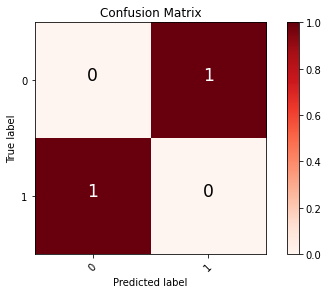

In [23]:
n_splits = 2
n_epochs = 10
batch_size = 1

trues = []
preds = []
losses = []
accuracies = []
splits = []
split_no = 1

kfold = KFold(n_splits=n_splits)

for train_index, test_index in kfold.split(test_set):
  X_train, X_test = test_set[train_index], test_set[test_index]
  y_train, y_test = label_test[train_index], label_test[test_index]
  #apply transfer learning to base model
  model = get_tl_model(base_model)

  model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size,
                 validation_data = (X_test, y_test))
  
  #predictions
  y_true = y_test
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #append to list
  trues.extend(y_true)
  preds.extend(y_pred)

  #evaluate model
  loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(acc * 100)
  losses.append(loss)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", acc*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, preds, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Repeat with LSTM model**

In [12]:
#fear files
#test set is FM01
train_set = fear_nps[(np.where(fear_groups != '01'))]
test_set = fear_nps[np.where(fear_groups == '01')] 

label_train = fear_labels[(np.where(fear_groups != '01'))]
label_test = fear_labels[(np.where(fear_groups == '01'))] 

#vars for training
n_epochs = 25
batch_size = 8
verbose = 2

class_names = [0, 1]

base_model = create_lstm_model()

#fit model
history = base_model.fit(train_set, label_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size)

Epoch 1/25
6/6 - 2s - loss: 0.7084 - accuracy: 0.4545
Epoch 2/25
6/6 - 2s - loss: 0.6944 - accuracy: 0.5000
Epoch 3/25
6/6 - 2s - loss: 0.6899 - accuracy: 0.4773
Epoch 4/25
6/6 - 2s - loss: 0.6998 - accuracy: 0.4773
Epoch 5/25
6/6 - 2s - loss: 0.7282 - accuracy: 0.5000
Epoch 6/25
6/6 - 2s - loss: 0.7035 - accuracy: 0.5000
Epoch 7/25
6/6 - 2s - loss: 0.7140 - accuracy: 0.5000
Epoch 8/25
6/6 - 2s - loss: 0.7127 - accuracy: 0.4773
Epoch 9/25
6/6 - 2s - loss: 0.7031 - accuracy: 0.5000
Epoch 10/25
6/6 - 2s - loss: 0.6984 - accuracy: 0.5000
Epoch 11/25
6/6 - 2s - loss: 0.6937 - accuracy: 0.5000
Epoch 12/25
6/6 - 2s - loss: 0.6969 - accuracy: 0.5000
Epoch 13/25
6/6 - 2s - loss: 0.6811 - accuracy: 0.5000
Epoch 14/25
6/6 - 2s - loss: 0.6897 - accuracy: 0.5000
Epoch 15/25
6/6 - 2s - loss: 0.7028 - accuracy: 0.5000
Epoch 16/25
6/6 - 2s - loss: 0.7244 - accuracy: 0.4545
Epoch 17/25
6/6 - 2s - loss: 0.6872 - accuracy: 0.5000
Epoch 18/25
6/6 - 2s - loss: 0.6952 - accuracy: 0.5000
Epoch 19/25
6/6 - 2

Epoch 1/10
1/1 - 1s - loss: 15.4249 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
1/1 - 0s - loss: 15.4249 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
1/1 - 0s - loss: 15.4249 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
1/1 - 0s - loss: 15.4249 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
1/1 - 0s - loss: 15.4249 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1/1 - 0s - loss: 3.0498 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
1/1 - 0s - loss: 1.5386 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8/10
1/1 - 0s - loss: 15.4249 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9/10
1/1 - 0s - loss: 15.4249 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 10/10
1/1 - 0s - loss: 3.7252 - accuracy: 0.0000e+0

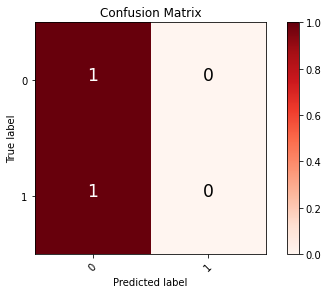

In [17]:
n_splits = 2
n_epochs = 10
batch_size = 1

trues = []
preds = []
losses = []
accuracies = []
splits = []
split_no = 1

kfold = KFold(n_splits=n_splits)

for train_index, test_index in kfold.split(test_set):
  X_train, X_test = test_set[train_index], test_set[test_index]
  y_train, y_test = label_test[train_index], label_test[test_index]
  #apply transfer learning to base model
  model = get_tl_model(base_model)

  model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size,
                 validation_data = (X_test, y_test))
  
  #predictions
  y_true = y_test
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #append to list
  trues.extend(y_true)
  preds.extend(y_pred)

  #evaluate model
  loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(acc * 100)
  losses.append(loss)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", acc*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, preds, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Repeat transfer learning experiment with anger files**

In [24]:
#test set is FM01
train_set = anger_nps[(np.where(anger_groups != '01'))]
test_set = anger_nps[np.where(anger_groups == '01')] 

label_train = anger_labels[(np.where(anger_groups != '01'))]
label_test = anger_labels[(np.where(anger_groups == '01'))] 

#vars for training
n_epochs = 25
batch_size = 8
verbose = 2

class_names = [0, 1]

base_model = create_cnn_model()

#fit model
history = base_model.fit(train_set, label_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size)

Epoch 1/25
6/6 - 0s - loss: 14.3357 - accuracy: 0.5111
Epoch 2/25
6/6 - 0s - loss: 1.5520 - accuracy: 0.4889
Epoch 3/25
6/6 - 0s - loss: 1.1284 - accuracy: 0.4889
Epoch 4/25
6/6 - 0s - loss: 0.7707 - accuracy: 0.4222
Epoch 5/25
6/6 - 0s - loss: 1.0194 - accuracy: 0.4000
Epoch 6/25
6/6 - 0s - loss: 1.0758 - accuracy: 0.3111
Epoch 7/25
6/6 - 0s - loss: 0.6851 - accuracy: 0.5556
Epoch 8/25
6/6 - 0s - loss: 0.7694 - accuracy: 0.4000
Epoch 9/25
6/6 - 0s - loss: 0.7437 - accuracy: 0.5111
Epoch 10/25
6/6 - 0s - loss: 0.6869 - accuracy: 0.5778
Epoch 11/25
6/6 - 0s - loss: 0.7151 - accuracy: 0.4889
Epoch 12/25
6/6 - 0s - loss: 0.6991 - accuracy: 0.4667
Epoch 13/25
6/6 - 0s - loss: 0.7279 - accuracy: 0.3556
Epoch 14/25
6/6 - 0s - loss: 0.7072 - accuracy: 0.3333
Epoch 15/25
6/6 - 0s - loss: 0.7023 - accuracy: 0.5111
Epoch 16/25
6/6 - 0s - loss: 0.7007 - accuracy: 0.5333
Epoch 17/25
6/6 - 0s - loss: 0.7016 - accuracy: 0.4667
Epoch 18/25
6/6 - 0s - loss: 0.7181 - accuracy: 0.3111
Epoch 19/25
6/6 - 

Epoch 1/10
1/1 - 0s - loss: 0.6602 - accuracy: 1.0000 - val_loss: 2.1992 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 - 0s - loss: 0.1175 - accuracy: 1.0000 - val_loss: 4.0560 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 - 0s - loss: 0.0175 - accuracy: 1.0000 - val_loss: 5.7098 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 - 0s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 7.1475 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 - 0s - loss: 7.8713e-04 - accuracy: 1.0000 - val_loss: 8.4198 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 - 0s - loss: 2.2048e-04 - accuracy: 1.0000 - val_loss: 9.5633 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 - 0s - loss: 7.0266e-05 - accuracy: 1.0000 - val_loss: 10.5875 - val_accuracy: 0.0000e+00
Epoch 8/10
1/1 - 0s - loss: 2.5229e-05 - accuracy: 1.0000 - val_loss: 11.5172 - val_accuracy: 0.0000e+00
Epoch 9/10
1/1 - 0s - loss: 9.9569e-06 - accuracy: 1.0000 - val_loss: 12.3630 - val_accuracy: 0.0000e+00
Epoch 10/10
1/1 - 0s - loss: 4.2740e-06 - accuracy: 1.0000 - val_loss: 13.128

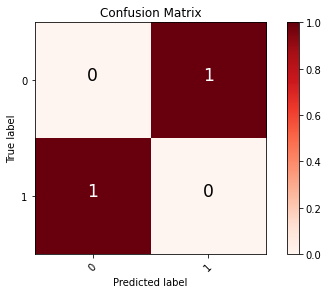

In [25]:
n_splits = 2
n_epochs = 10
batch_size = 1

trues = []
preds = []
losses = []
accuracies = []
splits = []
split_no = 1

kfold = KFold(n_splits=n_splits)

for train_index, test_index in kfold.split(test_set):
  X_train, X_test = test_set[train_index], test_set[test_index]
  y_train, y_test = label_test[train_index], label_test[test_index]
  #apply transfer learning to base model
  model = get_tl_model(base_model)

  model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size,
                 validation_data = (X_test, y_test))
  
  #predictions
  y_true = y_test
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #append to list
  trues.extend(y_true)
  preds.extend(y_pred)

  #evaluate model
  loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(acc * 100)
  losses.append(loss)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", acc*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, preds, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**LSTM**

In [18]:
#test set is FM01
train_set = anger_nps[(np.where(anger_groups != '01'))]
test_set = anger_nps[np.where(anger_groups == '01')] 

label_train = anger_labels[(np.where(anger_groups != '01'))]
label_test = anger_labels[(np.where(anger_groups == '01'))] 

#vars for training
n_epochs = 25
batch_size = 8
verbose = 2

class_names = [0, 1]

base_model = create_lstm_model()

#fit model
history = base_model.fit(train_set, label_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size)

Epoch 1/25
6/6 - 2s - loss: 0.7572 - accuracy: 0.4889
Epoch 2/25
6/6 - 2s - loss: 0.6949 - accuracy: 0.5778
Epoch 3/25
6/6 - 2s - loss: 0.7237 - accuracy: 0.4222
Epoch 4/25
6/6 - 2s - loss: 0.7501 - accuracy: 0.3778
Epoch 5/25
6/6 - 2s - loss: 0.7155 - accuracy: 0.4889
Epoch 6/25
6/6 - 2s - loss: 0.7061 - accuracy: 0.4889
Epoch 7/25
6/6 - 2s - loss: 0.7206 - accuracy: 0.4889
Epoch 8/25
6/6 - 2s - loss: 0.6957 - accuracy: 0.4889
Epoch 9/25
6/6 - 2s - loss: 0.7140 - accuracy: 0.4889
Epoch 10/25
6/6 - 2s - loss: 0.6981 - accuracy: 0.4444
Epoch 11/25
6/6 - 2s - loss: 0.7094 - accuracy: 0.5111
Epoch 12/25
6/6 - 2s - loss: 0.7335 - accuracy: 0.4000
Epoch 13/25
6/6 - 2s - loss: 0.7061 - accuracy: 0.4889
Epoch 14/25
6/6 - 2s - loss: 0.7233 - accuracy: 0.4444
Epoch 15/25
6/6 - 2s - loss: 0.6806 - accuracy: 0.4889
Epoch 16/25
6/6 - 2s - loss: 0.7414 - accuracy: 0.4889
Epoch 17/25
6/6 - 2s - loss: 0.7155 - accuracy: 0.4889
Epoch 18/25
6/6 - 2s - loss: 0.6962 - accuracy: 0.4889
Epoch 19/25
6/6 - 2

Epoch 1/10
1/1 - 1s - loss: 15.4249 - accuracy: 0.0000e+00 - val_loss: 0.0719 - val_accuracy: 1.0000
Epoch 2/10
1/1 - 0s - loss: 1.9125 - accuracy: 0.0000e+00 - val_loss: 0.0719 - val_accuracy: 1.0000
Epoch 3/10
1/1 - 0s - loss: 2.2552 - accuracy: 0.0000e+00 - val_loss: 0.0719 - val_accuracy: 1.0000
Epoch 4/10
1/1 - 0s - loss: 2.0464 - accuracy: 0.0000e+00 - val_loss: 0.0719 - val_accuracy: 1.0000
Epoch 5/10
1/1 - 0s - loss: 15.4249 - accuracy: 0.0000e+00 - val_loss: 0.0719 - val_accuracy: 1.0000
Epoch 6/10
1/1 - 0s - loss: 15.4249 - accuracy: 0.0000e+00 - val_loss: 0.0719 - val_accuracy: 1.0000
Epoch 7/10
1/1 - 0s - loss: 15.4249 - accuracy: 0.0000e+00 - val_loss: 0.0719 - val_accuracy: 1.0000
Epoch 8/10
1/1 - 0s - loss: 15.4249 - accuracy: 0.0000e+00 - val_loss: 0.0719 - val_accuracy: 1.0000
Epoch 9/10
1/1 - 0s - loss: 15.4249 - accuracy: 0.0000e+00 - val_loss: 0.0719 - val_accuracy: 1.0000
Epoch 10/10
1/1 - 0s - loss: 3.4134 - accuracy: 0.0000e+00 - val_loss: 0.0719 - val_accuracy: 

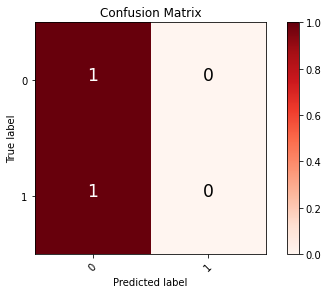

In [20]:
n_splits = 2
n_epochs = 10
batch_size = 1

trues = []
preds = []
losses = []
accuracies = []
splits = []
split_no = 1

kfold = KFold(n_splits=n_splits)

for train_index, test_index in kfold.split(test_set):
  X_train, X_test = test_set[train_index], test_set[test_index]
  y_train, y_test = label_test[train_index], label_test[test_index]
  #apply transfer learning to base model
  model = get_tl_model(base_model)

  model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size,
                 validation_data = (X_test, y_test))
  
  #predictions
  y_true = y_test
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #append to list
  trues.extend(y_true)
  preds.extend(y_pred)

  #evaluate model
  loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(acc * 100)
  losses.append(loss)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", acc*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, preds, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')